In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc #need to import 'inspect' in order to inspect the data later, and need 'desc'in order to arrange dates in descending order

In [6]:
# create engine to hawaii.sqlite
database_path = "Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")


In [7]:
# reflect an existing database into a new model
#Data models are Python classes representing a SQL table in our database
# Declare a Base using `automap_base()`and reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [26]:
# Find the most recent date in the data set.
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"],column["nullable"])


id INTEGER False
station TEXT True
date TEXT True
prcp FLOAT True
tobs FLOAT True


In [27]:
# Starting from the most recent data point in the database, calculate the date one year from the last date in data set.
#I designed a query to retrieve the start of the past 12 months in order to get precipitation data and plot the results.

import datetime
ordered_date=session.query(measurement.date, measurement.prcp).order_by(desc(measurement.date)).first()
recent_dt=ordered_date[0]
print("The most recent date in the data is", recent_dt)

#used date codes from here:https://www.listendata.com/2019/07/how-to-use-datetime-in-python.html
recent_date_form = datetime.datetime.strptime(ordered_date[0], '%Y-%m-%d')
recent_date=recent_date_form.date()
from dateutil.relativedelta import *
past_date=recent_date+relativedelta(years=-1)
print("Twelve months from the most recent date is", past_date)


The most recent date in the data is 2017-08-23
Twelve months from the most recent date is 2016-08-23


In [28]:
# Perform a query to retrieve the date and precipitation scores
toplot = session.query(measurement.date,measurement.prcp).filter(measurement.date>past_date).order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column and sort the dataframe by date
df=pd.DataFrame(toplot)
df['date'].unique()
df.dropna(how='any',inplace=True) #this drops any NaN values which would affect the plot
df = df.set_index('date')
df = df.sort_index()
df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


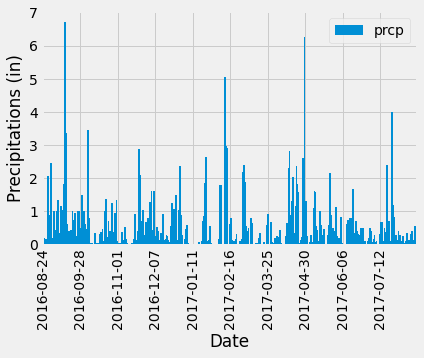

In [29]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind="bar",width=10,ylabel="Precipitations (in)",xlabel="Date")
plt.locator_params(axis='x', nbins=10)
plt.show()

In [30]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [20]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"],column["nullable"])

id INTEGER False
station TEXT True
name TEXT True
latitude FLOAT True
longitude FLOAT True
elevation FLOAT True


In [17]:
# Design a query to calculate the total number stations in the dataset
stations=session.query(station.station).count()
print("There are",stations,"stations in the dataset.")

There are 9 stations in the dataset.


In [45]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
st_counts=session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(desc(func.count(measurement.station))).all()
st_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [52]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
    #first find most active station (which is USC00519281)
st_active=session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(desc(func.count(measurement.station))).first()
st_active

('USC00519281', 2772)

In [77]:
    #Second, pull data for that station (lowest, highest, and average tobs)
temps = session.query(measurement.station,func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).filter(measurement.station==st_active[0]).first()

print(temps)

print("The lowest temp observed for the most active station, %s, was %d degress F." % (temps[0],temps[1]))
print("The highest temp observed for the most active station, %s, was %d degress F." % (temps[0],temps[2]))
print("The average temp observed for the most active station, %s, was %d degress F." % (temps[0],temps[3]))

('USC00519281', 54.0, 85.0, 71.66378066378067)
The lowest temp observed for the most active station, USC00519281, was 54 degress F.
The highest temp observed for the most active station, USC00519281, was 85 degress F.
The average temp observed for the most active station, USC00519281, was 71 degress F.


In [80]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
to_hist=session.query(measurement.station,measurement.date, measurement.tobs).filter(measurement.station==temps[0]).order_by(desc(measurement.date)).first()
recent_hist_dt=to_hist[1]
print(to_hist)
print("The most recent observed temperature at the most active station, "+ to_hist[0]+ ", happened on "+ recent_hist_dt +".")

recent_hist_dt_form = datetime.datetime.strptime(recent_hist_dt, '%Y-%m-%d')
recent_hist_dt=recent_hist_dt_form.date()
from dateutil.relativedelta import *
past_hist_date=recent_hist_dt+relativedelta(years=-1)
print("Twelve months from the most recent date is", past_hist_date)

('USC00519281', '2017-08-18', 79.0)
The most recent observed temperature at the most active station, USC00519281, happened on 2017-08-18.
Twelve months from the most recent date is 2016-08-18


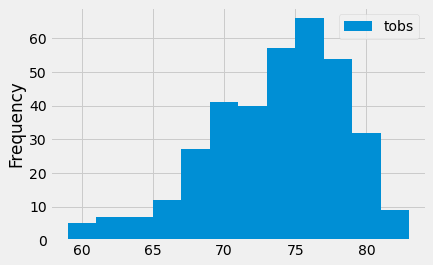

In [95]:
#Plot the results as a histogram
to_plot=session.query(measurement.date, measurement.tobs).filter(measurement.station==temps[0]).filter(measurement.date>=past_hist_date).all()
#print(to_plot)

hist_df= pd.DataFrame(to_plot)
hist_df.plot(kind="hist",bins=12)
plt.show()


# Close session

In [96]:
# Close Session
session.close()